## <center>Processamento de Linguagem Natural em Textos de Mídias Sociais: Fundamentos, Ferramentas e Aplicações</center>

### <center>XXVIII Simpósio Brasileiro de Sistemas Multimídia e Web (WebMedia 2022)</center>

<br></br>

<center>Frances A. Santos (UNICAMP), Jordan Kobellarz (UTFPR), Fábio R. de Souza (USP), Leandro A. Villas (UNICAMP), Thiago H. Silva (UTFPR)</center>

<br></br>

<center>Curitiba, PR</center>
<center>07 de Novembro de 2022</center>

<a href="https://colab.research.google.com/github/webmedia2022-nlp/course-code/blob/main/NLP_WebMedia2022.ipynb" target="_parent"><img style="float: right;" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Abrir no Colab"/></a>

In [ ]:
!pip install --no-cache-dir -r requirements.txt
!python -m spacy download en_core_web_sm #Instalando dependências específicas do spacy

In [1]:
%load_ext autoreload
%autoreload 2

import math
import warnings
import pathlib
import os 
import getpass
import pandas as pd
import numpy as np
import nltk
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from pathlib import Path

# Criação do diretório "data/"
Path("data").mkdir(parents=True, exist_ok=True)

from DataExtraction import DataExtraction
from Preprocessing import Preprocessing
from ModelosRepresentacao import ModelosEstatisticos, SentenceEmbeddings, WordEmbeddings
from ExtracaoConhecimento import Clustering, SemanticComprehension, SentimentAnalysis

warnings.filterwarnings('ignore')
tqdm.pandas()

2022-11-02 14:20:21.221903: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-11-02 14:20:21.222010: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-02 14:20:21.222363: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1660 Ti computeCapability: 7.5
coreClock: 1.59GHz coreCount: 24 deviceMemorySize: 5.80GiB deviceMemoryBandwidth: 268.26GiB/s
2022-11-02 14:20:21.222445: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2022-11-02 14:20:21.222484: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynami

In [2]:
# Download de arquivos usados por bibliotecas

try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
    
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/jordan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Agenda

1. Introdução 
2. Texto de mídias sociais: suas principais características e como coletá-los
3. Pré-processamento textual
4. Representação de textos utilizando vetores numéricos
5. Modelagem e extração de conhecimento
6. Compreensão semântica e emocional
7. Possíveis aplicações
8. Perguntas & Respostas

# <center>1. Introdução</center>

<img src="figs/social-media.jpeg" style="float: center; zoom:100%;" />

Mídias sociais são acessadas por aproximadamente 4,7 bilhões de usuários em todo o planeta (i.e., 59% da população) [Kemp 2022]

### Exemplo (Twitter):

* 200 Bilhões de postagens por ano
* equivalente a 6 mil postagens por segundo

Fonte: [Twitter Usage Statustics](https://www.internetlivestats.com/twitter-statistics)

### Possibilidades para acessar dados públicos em larga escala

* **Twitter** - API (stream e histórico)
* **Reddit** - API (stream e histórico)
* **Meta (Instagram e Facebook)** - Plataforma CrowdTangle
* **Swarm (Forsquare)** - API
* **Flickr** - API
* **Google Places** - API
* etc.

### Aplicações na academia

* análise de fenômenos sociais
* sensoriamento social
* detecção de notícias falsas
* discurso de ódio
* polarização política
* etc.

### Aplicações na indústria

* benchmarking (comparação com concorrentes)
* forecasting (análise de tendências)
* sistemas de recomendação
* personalização / customização em larga escala
* análise de risco
* etc.

# <center>2. Textos de mídias sociais</center>

### Onde encontrar dados textuais?

* postagens
* artigos
* mensagens / comentários
* metainformações de páginas, imagens, videos, perfis, postagens, mensagens, etc. 
* extração de texto em imagem, áudio e video
* etc.

## 2.1 Twitter

* Mídia social de *Microblogging*
* Mensagens limitadas a 280 caracteres
* Uma das primeiras redes a disponibilizar uma API para extração de dados públicos em larga escala
* Possibilidade de coleta de dados históricos ou em tempo real (*streaming*)
* Qualquer dado público pode ser acessado, exceto os de perfis privados (menos de 10%)

### Característica proeminente

Simplicidade nas interações e dicionário de dados:

* tweets
* hashtags #
* menções @
* retweets RT
* respostas

### Dados que podem ser obtidos via API

* **texto do tweet**
* **timestamp**
* **autor**
    * nome
    * localização
    * se é verificado
    * quantidade de seguidores, amigos, postagens
    * data de criação da conta
    * língua do perfil
    * etc.
* **geolocalização do tweet (GeoJson)**
    * adicionada explícitamente
    * ou capturada do dispositivo que gerou o tweet
* **entidades**
    * hashtags
    * links
    * menções
    * mídias
* **sinais sociais**
    * quantidade de retweets
    * quantidade de curtidas
    * quantidade de respostas
* etc. 

Conheça o [dicionário completo de dados de um tweet aqui](https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/object-model/tweet). 

### Exemplo de um tweet

Alguns campos foram omitidos para facilitar a visualização. 

```json
{
  "created_at": "Thu Apr 06 15:24:15 +0000 2017",
  "id_str": "850006245121695744",
  "text": "1\/ Today we\u2019re sharing our vision for the future of the Twitter API platform!\nhttps:\/\/t.co\/XweGngmxlP",
  "user": {
    "id": 2244994945,
    "name": "Twitter Dev",
    "screen_name": "TwitterDev",
    "location": "Internet",
    "url": "https:\/\/dev.twitter.com\/",
    "description": "Your official source for Twitter Platform news, updates & events. Need technical help? Visit https:\/\/twittercommunity.com\/ \u2328\ufe0f #TapIntoTwitter"
  },
  "place": {   
  },
  "entities": {
    "hashtags": [      
    ],
    "urls": [
    ],
    "user_mentions": [     
    ]
  }
}
```

### Limitações e desafios

* Limite de 280 caracteres
    * restringe capacidade argumentativa
    * usuários contornam com uso de contrações de palavras, gírias da internet e emojis
* Representatividade da população
    * pode não representar bem o usuário médio de internet
    * [tendem a ser usadas por pessoas mais jovens, com maior renda e grau de escolaridade](https://blogs.oii.ox.ac.uk/policy/did-you-consider-twitters-lack-of-representativeness-before-doing-that-predictive-study/)
* Representatividade do retorno da API
    * a API de streaming se baseia na [**relevância** e não **completude** dos dados](https://developer.twitter.com/en/docs/twitter-api/v1/tweets/search/overview)
* Alta incidência de contas robô

### Coletando Tweets

- Utilizaremos a Twitter API v2 para coletar os tweets 
- Acesse a [página de desenvolverdores](https://developer.twitter.com/) e obtenha suas credenciais de acesso
- Limitamos cada coleta a 10 tweets, mas todo o conteúdo dos tweets é adicionado (*appending*) ao arquivo local data/tweets.json
- Além dos campos *id* e *text* que estão presentes nos tweets por padrão, também solicitamos os campos *created_at, entities, geo, lang, public_metrics, source*. Para ver a lista completa de campos possíveis, acesse esta [página](https://developer.twitter.com/en/docs/twitter-api/data-dictionary/object-model/tweet)
- Filtramos para selecionar apenas os tweets escritos em Inglês ( *lang = "en"* ) e que contenham o termo "nyc", que referencia a cidade de Nova Iorque
- Após coletar os tweets, extraímos os valores dos campos *text, timestamp_ms, ...* e retornamos no formato Pandas DataFrame. 

In [ ]:
# Credenciais da API do Twitter

print("Informe seu 'API KEY'")
twitter_consumer_key = getpass.getpass()

print("Informe seu 'API KEY SECRET'")
twitter_consumer_secret = getpass.getpass()

print("Informe seu 'ACCESS TOKEN KEY'")
twitter_access_token_key = getpass.getpass()

print("Informe seu 'ACCESS TOKEN SECRET'")
twitter_access_token_secret = getpass.getpass()

print("Informe seu 'Bearer TOKEN'")
twitter_bearer_token = getpass.getpass()

In [ ]:
# Coleta de tweets
df_tweets = DataExtraction().twitter(
    twitter_consumer_key, 
    twitter_consumer_secret, 
    twitter_access_token_key, 
    twitter_access_token_secret, 
    twitter_bearer_token
)

df_tweets.head()

## 2.2 Reddit

* mídia social baseada em fóruns de discussão
* comunidades/fóruns → \subreddits
* mais de 100K comunidades e 50 mi de usuários ativos diariamente em [2020](https://www.redditinc.com/advertising/audience)

### Características proeminentes

* sistema de moderação autoorganizável
    * \subreddits possuem regras próprias criadas pelos moderadores e membros
    * algumas comunidades possuem alto nível de comprometimento com as regras propostas
    * mecanismos de recompensa para colaboradores ativos
* possibilidade de coletar dados em stream e histórico
    * vantagem de permitir a recuperação do histórico completo
* permite acesso à qualquer informação disponível publicamente
    * inclui postagens, comentários, perfis, comunidades e suas respectivas metainformações

### Dados que podem ser obtidos via API

**[submission (postagem)](https://praw.readthedocs.io/en/stable/code_overview/models/comment.html)**
* id
* url
* permalink
* created_utc
* title
* selftext (conteúdo da postagem)
* score (número de upvotes)
* [author](https://praw.readthedocs.io/en/stable/code_overview/models/comment.html) (Redditor)
    * name
    * created_utc
    * comment_karma (pontuação do usuário)
    * has_verified_email
    * etc.
* [comments](https://praw.readthedocs.io/en/stable/code_overview/models/comment.html) (árvore de comentários -- necessário percorrer com método específico para isso)
    * author (Redditor)
    * body
    * distinguished
    * etc.
* distinguished (se a postagem foi destacada pelo moderador)
* edited (se a postagem foi editada)
* is_original_content (se foi marcada automaticamente como conteúdo original)
* over_18 (se é conteúdo para maiores de 18 anos)
* etc.

### Limitações e desafios

* a plataforma permite um alto grau de anonimidade
    * é encorajado o uso de pseudônimo
    * é possível fazer cadastro sem verificação
    * abertura para comportamentos anti-éticos em comunidades não moderadas / permissivas
* cada comunidade possui regras próprias
    * práticas de moderação distintas
    * dificultando a comparação 
* liberdade no formato
    * campo aberto com possibiidade de uso de html e markdown
* alta incidência de bots
    * criam, fazem a curadoria e moderam conteúdos 

### Coletando Posts de \subreddits

- Utilizaremos a [API do Reddit](https://www.reddit.com/dev/api) para coletar posts
- Você deverá criar uma conta para acessar a API em [reddit.com](https://reddit.com)
- Depois de criar a conta, obtenha os Client ID e o Client Secret
- No exemplo a seguir, coletamos os top 100 posts de 5 subreddits, contendo o texto, url, número de comentários, data de criação e score (número de upvotes do post)
- Os dados são salvos no arquivo local data/reddit_posts.csv

In [ ]:
# Credenciais da API do Reddit

print("Informe seu 'CLIENT ID'")
REDDIT_CLIENT_ID = getpass.getpass()

print("Informe seu 'CLIENT SECRET'")
REDDIT_CLIENT_SECRET = getpass.getpass()

In [ ]:
# Subreddits com discussões sérias sobre assuntos como política, história e ciência.
subreddits = [
    'politics',
    'AskHistorians',
    'changemyview',
    'COVID19',
    'EverythingScience',
    'science'
]

# Coleta os top 100 posts de cada Subreddit
df_reddit_posts = DataExtraction().reddit(
    REDDIT_CLIENT_ID,
    REDDIT_CLIENT_SECRET,
    subreddits=subreddits,
    top_n=100
)

In [ ]:
# Apresenta alguns posts com texto
df_reddit_posts[df_reddit_posts['length'] > 0].tail(5)

## 2.3 Facebook (Meta)

### Características proeminentes

* alto grau de controle de privacidade
* o anonimato é desencorajado 

### Formas de obter dados

* via API nativa (limitada)
* via web scraping (desencorajado)
* via polls com usuários (não escalável)
* via programa [Social Science One](https://socialscience.one/grant-process) (acesso direto à base do Facebook | difícil acesso | apenas para uso acadêmico)
* via plataforma do [CrowdTangle](https://crowdtangle.com) (dados limitados a páginas e grupos famosos)

### [CrowdTangle](https://crowdtangle.com)

* iniciativa da Meta criada para jornalistas, agências de checagem de fatos, profissionais de marketing e pesquisadores
* possibilidade de consultar e visualizar dados em tempo real pela interface (dashboards)
* mesmos dados apresentados na interface podem ser obtidos via API

* informações que **podem** ser coletadas:
     * quando algo foi postado
     * tipo do post (video, imagem, texto)
     * página, conta ou grupo onde o conteúdo foi postado
     * quantidade de interações (likes, reações, comentários, compartilhamentos, visualizações de videos)
     * páginas públicas ou contas que compartilharam o conteúdo

* informações que **não podem** ser coletadas:
    * alcance ou impressões de um post
    * conteúdos efêmeros, como stories, por exemplo
    * informações demográficas de usuários

* a base de dados disponível se limita a:
    * contas famosas (aprox. ~7 mi de páginas, grupos ou perfis verificados em 08/06/2021), incluindo:
        * páginas públicas com mais de 50K curtidas
        * grupos públicos com mais de 95K membros
        * grupos públicos dos Estados Unidos com mais de 2K membros
        * todos os perfis verificados

### Exemplo de retorno da API do CrowdTangle

```json
{
    "status": 200,
    "result": {
        "posts": [
            {
                "platformId": "47657117525_10154014482272526",
                "platform": "Facebook",
                "date": "2016-02-12 23:38:14",
                "updated": "2020-08-23 05:48:22",
                "type": "live_video_complete",
                "message": "Draymond at Foot Locker for #NBAAllStarTO with a special shoutout to #DubNation.",
                "expandedLinks": [
                    {
                        "original": "https://www.facebook.com/warriors/videos/10154014482272526/",
                        "expanded": "https://www.facebook.com/warriors/videos/10154014482272526/"
                    }
                ],
                "link": "https://www.facebook.com/warriors/videos/10154014482272526/",
                "postUrl": "https://www.facebook.com/warriors/posts/10154014482272526",
                "subscriberCount": 6041837,
                "score": 4.750579867017164,
                "media": [
                    {
                        "type": "video",
                        "url": "https://video-sea1-1.xx.fbcdn.net/v/t42.1790-29/12718926_1213464465334694_1083747983_n.mp4?_nc_cat=109&_nc_sid=985c63&efg=eyJybHIiOjQ0MiwicmxhIjoxNDIwLCJ2ZW5jb2RlX3RhZyI6InYyXzQwMF9jcmZfMjdfbWFpbl8zLjBfc2QifQ%3D%3D&_nc_ohc=e7Ygz2qv-24AX-wSWX2&rl=442&vabr=246&_nc_ht=video-sea1-1.xx&oh=889e0d776d92a84bb57099cad3d28d55&oe=5F43C879",
                        "height": 0,
                        "width": 0
                    },
                    {
                        "type": "photo",
                        "url": "https://scontent-sea1-1.xx.fbcdn.net/v/t15.5256-10/12526285_831341603658336_1493677499_n.jpg?_nc_cat=101&_nc_sid=1055be&_nc_ohc=DH0vfblGwtIAX_x8SBs&_nc_ht=scontent-sea1-1.xx&oh=b09d6378fa261fd45345e79c50c254cb&oe=5F696BE1",
                        "height": 400,
                        "width": 400,
                        "full": "https://scontent-sea1-1.xx.fbcdn.net/v/t15.5256-10/12526285_831341603658336_1493677499_n.jpg?_nc_cat=101&_nc_sid=1055be&_nc_ohc=DH0vfblGwtIAX_x8SBs&_nc_ht=scontent-sea1-1.xx&oh=b09d6378fa261fd45345e79c50c254cb&oe=5F696BE1"
                    }
                ],
                "statistics": {
                    "actual": {
                        "likeCount": 24235,
                        "shareCount": 753,
                        "commentCount": 5675,
                        "loveCount": 33,
                        "wowCount": 18,
                        "hahaCount": 3,
                        "sadCount": 0,
                        "angryCount": 5,
                        "thankfulCount": 0,
                        "careCount": 0
                    },
                    "expected": {
                        "likeCount": 3927,
                        "shareCount": 279,
                        "commentCount": 1041,
                        "loveCount": 1046,
                        "wowCount": 94,
                        "hahaCount": 45,
                        "sadCount": 14,
                        "angryCount": 19,
                        "thankfulCount": 0,
                        "careCount": 2
                    }
                },
                "account": {
                    "id": 19889,
                    "name": "Golden State Warriors",
                    "handle": "warriors",
                    "profileImage": "https://scontent-sea1-1.xx.fbcdn.net/v/t1.0-1/p200x200/74788912_10158146665972526_3545220405897723904_n.jpg?_nc_cat=1&ccb=2&_nc_sid=dbb9e7&_nc_ohc=9snUpG_pdlQAX90IhWM&_nc_ht=scontent-sea1-1.xx&tp=6&oh=f8a3d3b62b507966ecc68de3b557fe84&oe=5FBF1185",
                    "subscriberCount": 11580228,
                    "url": "https://www.facebook.com/47657117525",
                    "platform": "Facebook",
                    "platformId": "47657117525",
                    "accountType": "facebook_page",
                    "pageAdminTopCountry": "US",
                    "verified": true
                },
                "videoLengthMS": 307968,
                "liveVideoStatus": "completed",
                "Id": "19889|10154014482272526",
                "legacyid": 1686762829
            }
        ]
    }
}
```

### Limitações e desafios

* dados limitados a contas famosas
    * contas menos famosas são subrepresentadas
* não é possível saber quem reagiu ou comentou em posts
* ferramenta muito nova / pouco explorada

### Coletando Posts no CrowdTangle

* Utilizaremos a API do CrowdTangle para extrair posts do Facebook -- [documentação](https://github.com/CrowdTangle/API/wiki)
* O primeiro passo é criar uma conta no CrowdTangle, depois criar um dashboard e obter o token da API para acessar os dados do dashboard
* Para coletar posts via API, é necessário criar pelo menos uma lista em seu dashboard recém criado
* Em nosso caso, criaremos uma lista para monitorar posts de páginas de mídias de notícias, incluindo CNN, NYT, BBC, NBC, NPR, Reuters, etc. 
* [Esse video explica como usar a interface do CrowdTangle para criar listas](https://vimeo.com/588999918). 
* [Esse video explica como acessar os dados via API](https://vimeo.com/453763307) explicando como executar todos os procedimentos acima

> Observação: não é possível criar uma lista via API, somente pela interface do dashboard.

In [ ]:
# Credenciais da API do CrowdTangle

print("Informe seu 'API_TOKEN'")
CROWDTANGLE_API_TOKEN = getpass.getpass()

In [ ]:
# Aqui coletamos os top 100 posts em cada mês, iniciando em start_date e terminando em end_date
df_facebook_posts = DataExtraction().facebook(
    CROWDTANGLE_API_TOKEN, 
    search_term='covid-19',
    start_date = '2020-04-01',
    end_date = '2021-04-01'
)

In [ ]:
# Amostra de posts do Facebook
df_facebook_posts.tail(3)

# <center>3. Pré-processamento</center>

A tokenização é um método para...

In [ ]:
#APAGAR

import json

example_file = 'data/tweets.json'
tweets = open(example_file).read()
tweets = json.loads(tweets)

dados = [d['text'] for d in tweets]
import pandas as pd
dados = pd.DataFrame(dados, columns=['texto'])

In [ ]:
from Preprocessing import Preprocessing

pipeline = Preprocessing()

Normalização...

In [ ]:
dados['texto normalizado'] = dados['texto'].apply(pipeline.normalizacao)

dados.sample(2)

##### Regex (Expressoes regulares)

As expressão regulares são...

In [ ]:
remover_links = r'https?:\/\/.*[\r\n]*'
aplicar_regex = lambda x: pipeline.limpeza_regex(x, remover_links, valor='LINK')
dados['texto limpo'] = dados['texto normalizado'].apply(aplicar_regex)

remover_mentions = r'@([A-Za-z0-9_]+)'
aplicar_regex = lambda x: pipeline.limpeza_regex(x, remover_mentions, valor='USERNAME')
dados['texto limpo'] = dados['texto limpo'].apply(aplicar_regex)

dados.sample(2)

#### Tokenização


In [ ]:
dados['tokens'] = dados['texto limpo'].apply(pipeline.tokenizacao)

dados.sample(2)

A stemmização é um método para...

In [ ]:
dados['stems'] = dados['tokens'].apply(pipeline.stemmizacao)

dados.sample(2)

In [ ]:
dados['lemmas'] = dados['tokens'].apply(pipeline.lemmatizacao)

dados.sample(2)

### Outra Alternativa: Pipeline de NLP do Spacy

In [ ]:
#Fazendo tudo de uma só vez com Spacy

dados['tokens'], dados['pos tags'], dados['lemmas'] = zip(*dados['texto'].apply(pipeline.nlp_pipeline))

dados.sample(2)

### Modelos de Representação

Modelos Estatísticos

In [ ]:
modelos_stats = ModelosEstatisticos()
modelos_stats.bow(dados['texto'])

In [ ]:
modelos_stats.tfidf(dados['texto'])

In [ ]:
#TO-DO: PCA/SVD

Word Embeddings

In [ ]:
embeddings = WordEmbeddings()

In [ ]:
embeddings.word2vec(dados['texto'])

In [ ]:
embeddings.fasttext(dados['texto'])

## Sentence Embeddings

1. <span style="color:red">SkipThought</span>
2. InferSent
3. **Universal Sentence Encoder (USE)**
4. **SentenceBERT (SBERT)**
5. Language-Agnostic SEntence Representations (LASER)
6. Multilingual Universal Sentence Encoder (mUSE)
7. **Language-agnostic BERT Sentence Embedding (LaBSE)**


In [ ]:
sentences = [
    # Smartphones
    "I like my phone",
    "My phone is not good.",
    "Your cellphone looks great.",

    # Weather
    "Will it snow tomorrow?",
    "Recently a lot of hurricanes have hit the US",
    "Global warming is real",

    # Food and health
    "An apple a day, keeps the doctors away",
    "Eating strawberries is healthy",
    "Is paleo better than keto?",

    # Asking about age
    "How old are you?",
    "what is your age?",
]

## SkipThought
TBD

## InferSent
TBD

In [ ]:
# InferSent
# Na primeira execução, é feito o download de arquivos de modelos e embeddings
# Certifique-se de ter pelo menos 9GB disponíveis em disco para isso.
# Devido ao download, a primeira execução é lenta
infersent_embeddings = SentenceEmbeddings().infersent(sentences)
infersent_embeddings.shape

## USE
TBD

In [ ]:
# USE
# Na primeira execução, é feito o download de arquivos de modelos e embeddings
# Certifique-se de ter pelo menos 1GB disponível em disco para isso.
# Devido ao download, a primeira execução é lenta
use_embeddings = SentenceEmbeddings().use(sentences)
use_embeddings.shape

## SBERT
TBD

## SBERT

- Utilizaremos o modelo **all-MiniLM-L6-v2**, que é 5x mais rápido que sua versão base (**all-mpnet-base-v2**) e significativamente menor (de 420MB para 80MB), mas ainda mantém um bom desempenho
- O termo **all-** indica que o modelo foi treinado com todos os dados disponíveis (mais de 1 bilhão de pares de treinamento) e são projetados como modelos de propósito geral
- Para mais detalhes, acesse a página do [SBERT](https://www.sbert.net/docs/pretrained_models.html#)

In [ ]:
# SBERT
sbert_embeddings = SentenceEmbeddings().sbert(sentences)
sbert_embeddings.shape

## LASER
TBD

In [ ]:
# LASER
# Antes de utilizar o LASER, você deve fazer o download do modelo.
# Para isso, descomente a linha abaixo.
#!python -m laserembeddings download-models "data"
# Você pode informar o código de idioma (ISO 639-1), para cada sentença da lista.
# Por padrão, consideramos que todas as sentenças estão escritas em inglês ("en").
laser_embeddings = SentenceEmbeddings().laser(sentences)
laser_embeddings.shape

## mUSE
TBD

In [ ]:
# mUSE
# Na primeira execução, é feito o download de arquivos de modelos e embeddings
# Certifique-se de ter pelo menos 300MB disponível em disco para isso.
# Devido ao download, a primeira execução é lenta
muse_embeddings = SentenceEmbeddings().muse(sentences)
muse_embeddings.shape

## LaBSE
TBD

In [ ]:
# LaBSE
labse_embeddings = SentenceEmbeddings().labse(sentences)
labse_embeddings.shape

## Similaridade entre sentenças

TBD

In [ ]:
# Exemplo baseado em:
# https://www.tensorflow.org/hub/tutorials/semantic_similarity_with_tf_hub_universal_encoder

def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")


sent_emb = SentenceEmbeddings().labse(sentences) #escolha o modelo de sentence embeddings de sua preferência
plot_similarity(sentences, sent_emb, 90)

## Modelagem e Extração de Conhecimento

### Agrupamento de Textos
- k-means
- Agrupamento Hierárquico
- Detecção de Comunidades em Grafos

### k-means
TBD

### Agrupamento Hierárquico
TBD

### Detecção de Comunidades em Grafos
TBD

### Modelagem de Tópicos

* Objetivo: identificar estruturas semânticas em um corpus
* Processo não supervisionado
* A ordem das palavras não importa, portanto podem ser usadas representações como o Bag of Words (BoW) ou Tf-Idf

#### Exemplos em um corpus de notícias

* delimitar diferentes eventos (e.g., confronto entre Rússia e Ucrânia, Copa do Mundo, etc.)
* identificar grandes temas (e.g., economia, política, educação, etc.)
* pautas de discussão (e.g., aborto, questões climáticas, combate ao crime, etc.)
* !!! Ou todos os casos acima misturados -- o que é comum de acontecer

#### Funcionamento de um modelo de tópicos

* cada documento pode ser representado por um histograma com a contagem de cada termo contido nele
* a forma desse histograma é proveniente de uma distribuição entre $k$ tópicos 
* os $k$ tópicos são distribuídos entre os termos no vocabulário do corpus

O objetivo da modelagem de tópicos, então, é aprender essas distribuições.

<img src="figs/topic-model.png" style="float: center; zoom:100%;" />

Fonte: https://pyro.ai/examples/prodlda.html

#### Técnicas para modelagem de tópicos

* Latent Dirichlet Allocation (LDA)
* Latent Semantic Analysis (LSA) ou LSI (redução dimencional)
* Probabilistic Semantic Analysis (pLSA) (versão probabilística do LSA)

#### Pré-processamento para modelagem de tópicos

* tentar preservar palavras que podem ser representativas para o domínio
* não é necessário preservar a sequência dos termos

#### Desafios

Obs: os exemplos a seguir são de tópicos identificados em um corpus de páginas web sobre as Eleições de 2018 no Brasil e Eleições de 2019 no Canadá.

* Muitas vezes os tópicos são difíceis de serem caracterizados, necessitando conhecimento específico de domínio
    * e.g. "battisti, pf, italiano, italia, grafico, recurso, utc, extradicao, moro, deus"
    * e.g. "pipeline, climate, oil, energy, fossil_fuel, carbon, france, kinsella, people_party, industry"
* As top N palavras de um tópico nem sempre delimitam claramente o assunto
    * e.g. "ex_presidente, ciro_gomes, ciro, artista, cunha, universidade, dilma, eduardo, classificar, reeleicao"
* O valor $k$ é escolhido manualmente
    * mesmo usando métricas como score de coerência e distribuição dos tópicos ao longo do corpus, ainda é necessário o julgamento humano da adequabilidade do valor $k$
* Tópico evoluem ao longo do tempo (para isso existem modelos temporais de tópicos)

#### Exemplo prático

Ao final deste notebook, colocamos um exemplo prático usando o LDA em um dataset de notícias sobre as eleições canadenses de 2019.

## Compreensão Semântica e Emocional


### Detecção de Intenção

<img src="figs/ir-example.png" style="float: center; zoom:100%;" />

## Detecção de intenção
- Uma intenção fornece uma interpretação geral do significado de uma expressão
- Normalmente, é uma tarefa abstraída em um processo de classificação
- Para isso, o primeiro passo é a obtenção de um conjunto de expressões rotuladas (*corpus*) para treinamento do modelo de classificação
- Como veremos a seguir, existem muitos *corpus* disponíveis publicamente para essa tarefa.
- Mas, caso deseje preparar o seu próprio *corpus* com dados de mídias sociais, você pode utilizar a modelagem de tópicos para determinar quais assuntos estão presentes no *corpus* e realizar a separação dos dados e, então, revisar e rotular manualmente cada um deles.

### Corpus
- Iremos considerar o conjunto de dados disponível em [Wang, Jinpeng, et al.]<sup>[1](#footnoteIntentCorpus)</sup>
- Categorias de intenção nos *tweets*: **Food & Drink, Travel, Career & Education, Goods & Services, Event & Activities, Trifle, Non-intent**
- Veja na Tabela a seguir mais detalhes sobre os dados:

<center> Tabela: Intenções e exemplos do conjunto de dados [Wang, Jinpeng, et al.]<sup>1</sup> </center>

| Categoria | # (%) | Exemplo |
| --- | --- | --- |
| Food & Drink | 245 (11,5%) | hungry...i need a salad......four more days to the BEYONCE CONCERT... |
| Travel | 187 (8,78%) | I need a vacation really bad. I need a trip to Disneyland! |
| Career & Education | 159 (7,46%) | this makes me want to be a lawyer RT @someuser new favorite line from an ... |
| Goods & Services | 251 (11,78%) | mhmmm, i wannna a new phoneeee. ... i have to go to the hospital. ... |
| Event & Activities | 312 (15.07%) | on my way to go swimming with the twoon @someuser; i love her so muchhhhh! |
| Trifle | 436 (20,47%) | I'm so happy that I get to take a shower with myself. :D |
| Non-intent | 531 (24,92%) | So sad that Ronaldo will be leaving these shores...http://URL |


<a name="footnoteIntentCorpus">1</a>: Wang, Jinpeng, et al. "Mining user intents in twitter: A semi-supervised approach to inferring intent categories for tweets." Twenty-Ninth AAAI Conference on Artificial Intelligence. 2015.

### Modelo de Classificação de Intenções
<br>

<center>Redes Neurais Recorrentes (RNN) X Sentence Embeddings (imagem de [Feng et al. 2020])</center>

<img src="figs/bilstm-ir.png" style="float: left; zoom:60%;" />
<img src="figs/labse.png" style="float: right; zoom:60%;" />

In [ ]:
#temporario
intents = [
    "Smartphones",
    "Smartphones",
    "Smartphones",

    "Weather",
    "Weather",
    "Weather",

    
    "Food and health",
    "Food and health",
    "Food and health",
    
    "Asking about age",
    "Asking about age"
]

intent_labse_model, X_test_labse, y_test_labse, classes = SemanticComprehension().training_intents("labse", sentences, intents)


In [ ]:
# Epochs = 20
# Batch size = 32
# Hidden layers = 300
# Max sequence length = 280 --> tweet size
intent_bilstm_model, X_test_rnn, y_test_rnn, classes = SemanticComprehension().training_intents("bilstm", sentences, intents)


In [ ]:
# LaBSE's performance
y_hat = intent_labse_model.predict(X_test_labse)
SemanticComprehension().plot_confusion_matrix(y_test_labse, y_hat, classes, "figs/ir-labse-cm.png")

# RNN's performance
y_hat = intent_bilstm_model.predict(X_test_rnn)        
SemanticComprehension().plot_confusion_matrix(np.argmax(y_test_rnn,axis=1), np.argmax(y_hat, axis=1), classes, "figs/ir-rnn-cm.png")

### Matrix de Confusão
<br>

<center>Redes Neurais Recorrentes (RNN) X Sentence Embeddings</center>

<img src="figs/ir-rnn-cm.png" style="float: left; zoom:22%;" />
<img src="figs/ir-labse-cm.png" style="float: right; zoom:22%;" />

In [ ]:
# Predição de intents para os tweets coletados
intents = CompreensaoSemantica().predicao_intencoes(intent_labse_model, sentences) ## configurado apenas para o modelo LaBSE
intents.head()

### Reconhecimento de Entidades Nomeadas
TBD

### Corpus
- Iremos considerar o conjunto de dados disponível em  https://www.kaggle.com/code/amoghjrules/twitter-entity-recognition-using-bilstms
- abc

In [ ]:
entities = []
for sentence in tqdm(sentences):
    nlp = spacy.load('en_core_web_sm')
    doc = nlp(sentence)
    entity = {}
    for i, ent in enumerate(doc.ents):
        entity[i] = {
                        "value":ent.text,
                        "entity":ent.label_,
                        "start":ent.start_char,
                        "end":ent.end_char
                    }
    entities.append(entity)

print(entities[:3])

## Análise de Sentimentos (AS)

* Também conhecida como **Mineração de Opiniões**
* AS é o "estudo computacional das opiniões, atitudes e emoções de pessoas em relação a uma entidade" [Medhat et al. 2014]

### Tarefas de AS

* **Detecção de sentimento**
    - e.g. positivo, negativo ou neutro
* **Identificação de emoções**
    - e.g. sentimentos como raiva, antecipação, nojo, medo, alegria, tristeza, surpresa, confiança, etc. 
* **Detecção de toxicidade** 
    - e.g. categorias como insulto, profanidade, conteúdo sexualmente explícito, etc. [Jigsaw 2022]
* **Análise multilíngue de sentimentos**
* **Detecção de sarcasmo**
* etc.

### Exemplos de aplicações de AS

* Identificação de comentários agressivos em notícias [Jigsaw 2022]
* Extração da opinião pública sobre um candidato ou partido político [Pang et al. 2008]
* Priorização de respostas a avaliações negativas de produtos [Bougie et al. 2003] 
* etc.

### Vantages da AS

* Permite análises em larga escala
* Reduz a subjetividade provocada por avaliadores humanos

### Níveis da AS

1. **Nível de documento** - premissa: documento expressa opinião sobre apenas uma entidade; 
2. **Nível de frase** - premissa: frase expressa opinião sobre apenas uma entidade;  
3. **Nível de aspecto** - múltiplas opiniões sobre múltiplos aspectos (ou alvos)
    - e.g. “A <span style="color:#f00">qualidade de voz</span> deste telefone <span style="color:#f00">não é boa</span>, mas a <span style="color:#00f">vida útil da bateria</span> é <span style="color:#00f">longa</span>”

### Abordagens para criação de modelos de AS

1. **Usando Léxicos** 
    * <span style="color: #088B00">VANTAGEM</span>: independência de domínio
    * <span style="color: #f00">DESVANTAGEM</span>: menor precisão e baixa escalabilidade
2. **Aprendizado de máquina (ML)**
    * <span style="color: #088B00">VANTAGEM</span>: maior precisão
    * <span style="color: #f00">DESVANTAGEM</span>: maior dependência de domínio
3. **Híbrido (léxico + ML)** 

### A seguir iremos apresentar

* EmoLex
* LIWC
* Perspective API

In [ ]:
# Frases que vamos usar como exemplo para os modelos de AS

emotional_sentences = [

    # exemplo de frase positiva
    "How good it is to live in Curitiba!",

    # exemplo de frase neutra
    "This car is grey.",

    # exemplo de frase negativa
    "Shut up, you're an idiot!",

    # exemplo de frase negativa, mas com palavras que podem confundir o modelo de AS como "friend"
    "It must be so sad to have you as a friend"
]

### EmoLex

* Criado em 2013, é um dos maiores léxicos disponíveis em língua Inglesa
* Baseado em unigramas e bigramas dos léxicos
    * General Inquirer Lexicon
    * WordNet Affect Lexicon
* Anotações feitas via crowdsourcing pelo Mechanical Turk
* Associa palavras com as oito emoções da teoria de Plutchik [Plutchik 1980]
    * raiva, medo, antecipação, confiança, surpresa, tristeza, alegria e desgosto
* Também inclui as catergorias de sentimento negativo e positivo

In [ ]:
# Exemplo de sentenças processadas com o Emolex (frequência de emoções nas sentenças)
EmotionComprehension.emolex(emotional_sentences)

### LIWC

* Ferramenta para identificar características linguísticas, psicológicas e sociais em textos [Pennebaker et al. 2001]
* AS baseada em léxico (um dos maiores e mais completos na quantidade de termos e categorias cobertas)
* Léxicos separados para línguas diferentes, sendo o inglês a língua padrão
* Disponível apenas para Windows via interface gráfica

#### Categorias de conteúdo disponíveis no LIWC

* **emoções positivas** (e.g. amor, legal, doce, etc.)
* **emoções negativas** (e.g. ferido, feio, desagradável, etc.)
* **processos sociais** (e.g. filha, marido, vizinho, adulto, bebê, etc.)
* **processos cognitivos** (e.g. pensar, conhecer, causa, etc.)
* **processos perceptivos** (e.g. observar, escutar, sentir, etc.)
* **processos biológicos** (e.g. comer, sangue, dor, etc.)
* **relatividade** (e.g. chega, vai, embaixo, ontem, até, fim, etc.)
* **preocupações sociais** (e.g. auditar, igreja, cozinhar, trabalhar, mestrado, etc.)
* **consentimento** (e.g. concordar, ok, etc.)
* **não-fluências e palavras de preenchimento** (e.g. hm, er, umm, certo, etc.)
* entre outras [Tausczik and Pennebaker 2010]

#### Categorias de função disponíveis no LIWC

* **pronomes** 
* **preposições** 
* **artigos** 
* **conjunções** 
* **verbos auxiliares** 
* entre outras [Tausczik and Pennebaker 2010]

#### Interface do LIWC

<img src="figs/liwc.png" style="float: center; zoom:100%;" />

#### Exemplo de processamento com o LIWC

Para executar o processamento das sentenças de exemplo, será necessário [adquirir uma licença](https://www.liwc.app/buy), instalar o LIWC em um computador com Windows e processar o arquivo .csv gerado na célula a seguir. 

Você também poderá usar a versão de [teste online](https://www.liwc.app/demo), inserindo manualmente cada uma das sentenças geradas no .csv a seguir (essa versão é limitada a algumas poucas categorias, mas estão disponíveis as categorias de "Negative tone" e "Positive tone", bastante úteis em tarefas de AS). 

In [ ]:
# cria um .csv com exemplos para ser processado pelo LIWC
pd.DataFrame({'text': emotional_sentences}).to_csv('data/emotional_sentences_LIWC.csv', index=False)

In [ ]:
# carrega o arquivo com exemplos processado pelo LIWC
df_LIWC = pd.read_csv('emotional_sentences_LIWC.csv')

# apresenta apenas algumas colunas mais interessantes para AS
df_LIWC[['text', 'affect', 'posemo', 'negemo', 'anx', 'anger', 'sad']]

### Perspective API

* Usado para identificação de toxicidade em comentários online
* Modelo multilíngue
* Disponibilizado gratuitamente por meio de uma iniciativa da Jigsaw, uma empresa da Google [Jigsaw 2022]
* Acessado via API pública
* Adotada pelos principais veículos jornalísticos internacionais para moderar comentários em seus portais

#### Desafios para identificar toxicidade em comentários

* Geralmente são textos curtos - ex.: “sei… 😏”, “¬¬”, “no way!”
* Uso de emojis ambíguos - ex.: 😏,🌚,😋 
* Erros de ortografia propositais (ou não) - ex.: “çocorro”;
* Gírias da internet - ex.: “vc”, “pq”, “lol”, “iti malia”
* Sutilezas inerentes à língua ou localidade - ex.: “oxi”, “p**ra!”;
* Especificidades de contexto - ex.: “ex-presidiário”, “bozo”;
* Uso de figuras de linguagem - ex.: metáfora, ironia, etc.;
* Susceptíveis a ataques adversários - ex.: “st.Up1d”
* Podem ocorrer de forma esparsa no conjunto de dados;

#### Definição de comentário tóxico

<center>"Um comentário rude, desrespeitoso ou irracional que provavelmente fará você sair de uma discussão."</center>

#### Funcionamento do Perspective API

* Atribui uma pontuação contínua entre 0 e 1 para diferentes categorias de toxicidade de acordo com o % no texto
* Uma pontuação mais alta para uma determinada categoria (ou atributo), indica uma maior probabilidade de um leitor perceber que o comentário possui este atributo
* e.g. “Você é um idiota” pode receber uma pontuação de $0.8$ para o atributo TOXICIDADE, indicando que 8 entre 10 pessoas perceberiam esse comentário como tóxico
* Portanto um comentário com pontuação de TOXICIDADE de $0.9$ não necessariamente é mais tóxico  que uma com $0.7$

 [Jigsaw 2022]

<img src="figs/perspective.png" style="float: center; zoom:100%;" />

Fonte: https://perspectiveapi.com/

#### Atributos de produção (multilíngue)

- **TOXICITY** - “Um comentário rude, desrespeitoso ou irracional que provavelmente fará com que as pessoas deixem uma discussão”; 
- **SEVERE_TOXICITY** - “Um comentário que é muito odioso, agressivo, desrespeitoso, ou muito provável de fazer um usuário sair de uma discussão, ou desistir de compartilhar sua perspectiva. Este atributo é muito menos sensível a formas mais leves de toxicidade, como comentários que incluem usos positivos de palavrões”; 
- **IDENTITY_ATTACK** - “Comentários negativos ou de ódio direcionados a alguém por causa de sua identidade”; 
- **INSULT** - “Comentário ofensivo, inflamatório ou negativo para uma pessoa ou grupo de pessoas”; 
- **PROFANITY** - “Xingamentos, palavrões ou outras linguagens obscenas, ou profanas”; 
- **THREAT** - “Descreve a intenção de infligir dor, lesão ou violência contra um indivíduo, ou grupo”.

#### Acessando o Perspective API

* Para executar os exemplos a seguir, você deverá solicitar acesso ao Perspective API no Google Cloud seguindo [esse passo a passo](https://developers.perspectiveapi.com/s/docs-get-started)
* Obtenha a chave da API para usar nos próximos passos

In [ ]:
# Credenciais do Perspective API

print("Informe seu 'API KEY'")
PERSPECTIVE_API_KEY = getpass.getpass()

In [ ]:
# Exemplo de sentenças processadas com o Perspective API
EmotionComprehension.perspective(emotional_sentences, PERSPECTIVE_API_KEY)

# <center>6. Aplicações</center>

## 6.1 Polarização Política

TODO: contextualizar a seção

### Análise e pré-processamento

#### Carregando os conjuntos de dados de notícias e retweets com links para as notícias

In [3]:
def load_dataframe_from_drive_csv(url):
    path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
    return pd.read_csv(path)

# news dataset
url = 'https://drive.google.com/file/d/1AQjdqe9QRFK7ydNteZPM_IJk1eH-H3n_/view?usp=share_link'
df_news = load_dataframe_from_drive_csv(url)

# retweeted links dataset
url = 'https://drive.google.com/file/d/1Nn0I_tZnBWgUTNDeeE4bGzVTBhrTOJo1/view?usp=share_link'
df_retweeted_urls = load_dataframe_from_drive_csv(url)

#### Quantidade de notícias no conjunto de dados

In [4]:
df_news.shape[0]

484

#### Exemplos de dados 

In [5]:
pd.set_option('display.max_colwidth', 100)
df_news[['retweets_count', 'title', 'description', 'article']].sort_values('retweets_count', ascending=False)[:5]

,retweets_count,title,description,article
0,710,Liberal MP involved in cannabis start-up did not publicly disclose involvement,Mississauga-Lakeshore incumbent Sven Spengemann told The Globe and Mail he agreed to be on the b...,"Sven Spengemann, second from left, seen here in Ottawa on May 16, 2019, could not answer when he..."
1,663,Our endorsement: Best choice for Canada is Andrew Scheer,Andrew Scheer’s Conservatives are the only choice for those who understand that Canada today req...,"This advertisement has not loaded yet, but your article continues below.\nOur endorsement: Best ..."
2,552,Conservative Platform Includes $53 Billion in Cuts - including $14 Billion in hidden cuts,NaN,Conservative Platform Includes $53 Billion in Cuts – including $14 Billion in hidden cuts\nShare...
3,498,WARREN: Justin Trudeau deserves another shot - here’s why,Justin Trudeau is the best candidate for Prime Minister in the 2019 federal election and deserve...,"This advertisement has not loaded yet, but your article continues below.\nWARREN: Justin Trudeau..."
4,487,Election 2021 | CTV News | Canada Election Coverage,"CTV News Election 2021 coverage, top Canada election headlines and live breaking election Canada...","The election campaign is underway. Who will you be voting for, and when, and where? When will th..."


#### Remoção de notícias duplicadas

In [6]:
df_news = df_news.drop_duplicates(subset=['title', 'url'])

#### Combinação do título + descrição + corpo do artigo em uma única string

In [7]:
df_news['text'] = df_news['title'].astype(str) + ' ' + df_news['description'].astype(str) + ' ' + df_news['article'].astype(str)

#### Estatísticas sobre o tamanho dos textos

* Textos longos (> 4500 caracteres em média)
* O menor texto tem 310 caracteres

In [8]:
df_news['text_length'] = df_news['text'].apply(len)

In [9]:
df_news['text_length'].describe()

count      484.000000
mean      4678.946281
std       3921.687358
min        312.000000
25%       2373.500000
50%       4598.000000
75%       6098.000000
max      62940.000000
Name: text_length, dtype: float64

#### Exemplos de notícias

* Escrita formal
* Sem erros de ortografia

In [10]:
for content in df_news.sample(3)['text'].to_list():
    print(content[:500], '\n')

None-of-the-above campaign turns to talk of possible Prime Minister Andrew Scheer For the Conservatives, it is almost like an accident. Mr. Scheer’s party hasn’t gained an inch in opinion polls over the course of the campaign Conservative Leader Andrew Scheer, seen campaigning in Winnipeg on Oct. 14, 2019, would need help in votes if he were to become Prime Minister.CARLOS OSORIO/Reuters
Perhaps the best thing that happened to Conservative Leader Andrew Scheer in this election campaign was getti 

Man suddenly cares about homeless, veterans after hearing about Canada’s humanitarian aid to Syria nan SUDBURY, ON – Upon learning that the federal government is sending $840 million worth of humanitarian assistance to war-torn Syria, local man Brian Meilleur expressed a sudden interest and compassion for Canada’s homeless and veterans.
“We should be taking care of veterans and homeless first,” said Meilleur in a Facebook post to his friends.
This spontaneous public statement of sympathy wasn

#### Pré-processamento dos textos

* Remoção de 
    * links 
    * caracteres isolados 
    * stop-words
* Lematização usando Spacy
* Transoformação em lowercase

In [11]:
import unidecode
import re

# Instalação das dependências em inglês para a biblioteca Spacy
# python -m spacy download en_core_web_sm
spacy_nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Stopwords em inglês contidas na biblioteca Spacy
stop_words = list(spacy_nlp.Defaults.stop_words)

# Stopwords em inglês contidas na biblioteca do NLTK
stop_words += nltk.corpus.stopwords.words('english')

# Algumas outras palavras para serem removidas além das stop-words
stop_words += [
    '-pron-', 'video', 'try', 'refresh', 'continue', 'article', 'load', 'browser', 'say', 'will', 
    'would', 'content', 'news', 'sign', 'register', 'home', 'page', 'advertisement'
]


def preprocess(text):

    # Remoção de links 
    text = re.sub(r'http\S+', '', text)

    # Transforma o texto em um documento Spacy
    spacy_doc = spacy_nlp(text)

    # Usa o Spacy para lematizar o texto e remover stop words
    tokens = [token.lemma_.lower() for token in spacy_doc if token.lemma_.lower() not in stop_words]

    # Remove caracteres isolados
    tokens = [token for token in tokens if len(token) > 1]

    return tokens

In [12]:
df_news['text'] = df_news['text'].apply(preprocess)

#### Exemplos de notícias pré-processadas

In [13]:
df_news['text'][:10]

0    [liberal, mp, involve, cannabis, start, publicly, disclose, involvement, mississauga, lakeshore,...
1    [endorsement, good, choice, canada, andrew, scheer, andrew, scheer, conservative, choice, unders...
2    [conservative, platform, include, 53, billion, cuts, include, 14, billion, hide, cut, nan, conse...
3    [warren, justin, trudeau, deserve, shot, justin, trudeau, good, candidate, prime, minister, 2019...
4    [election, 2021, ctv, canada, election, coverage, ctv, election, 2021, coverage, canada, electio...
5    [poll, 25, think, trudeau, second, term, good, justin, trudeau, liberals, head, english, languag...
6    [goldstein, fiscal, folly, justin, trudeau, fiscal, plan, political, party, head, oct., 21, elec...
7    [elect, blackface, prime, minister, canada, joke, world, post, millennial, present, round, black...
8    [cbc, brand, liberal, election, cbc, fealty, trudeau, state, broadcaster, annual, 1.1, billion, ...
9    [john, ivison, trudeau, believe, canadians, long, 

#### Frequência de termos mais representativos após o pré-processamento

In [14]:
# Seta os padrões default para o matplot
plt.rcParams.update(plt.rcParamsDefault)

def get_all_terms(corpus):
    terms = []
    for text in corpus:
        terms = terms + text
    return terms


def term_frequency(corpus, num_plot=50, num_show=1000):
    plt.figure(figsize=(15, 5)) 

    terms = get_all_terms(corpus)
    fdist = nltk.FreqDist(terms)

    if num_plot > 0:
        fdist.plot(num_plot)

    # return a dataframe with terms and frequencies
    data = [[term, frequency] for term, frequency in fdist.most_common(num_show)]
    return pd.DataFrame(data, columns=['TERM', 'FREQUENCY'])

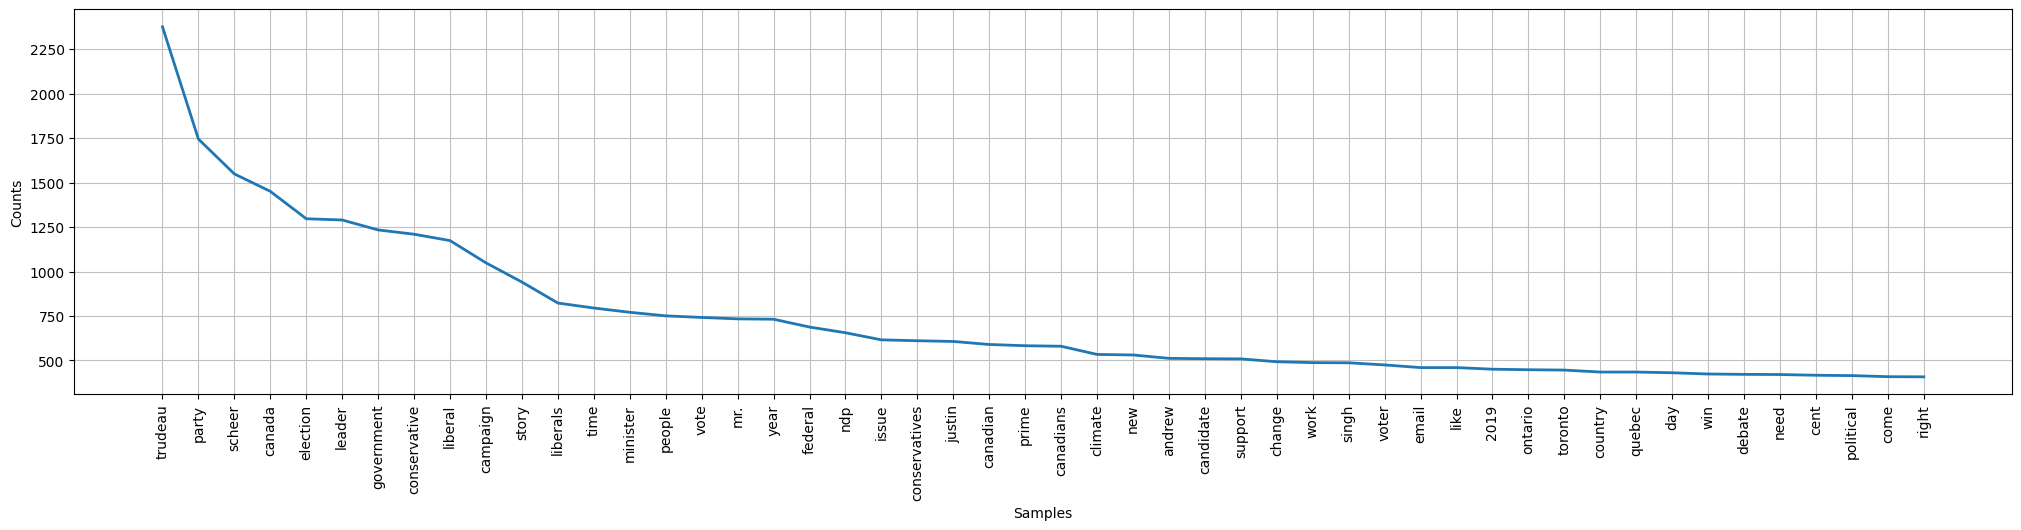

In [15]:
df_terms = term_frequency(df_news['text'])

#### Geração de bi e trigramas

Usando o Gemsim para formar bi e trigramas caso os termos coocorram pelo menos 10 vezes:

In [16]:
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim.models import CoherenceModel


def make_trigrams(corpus, min_count=5, threshold=10):

    # Criar os modelos de bi e trigramas

    # Obs.: quanto maior o threshold, menos N-gramas são formados
    bigram = Phrases(corpus, min_count=min_count, threshold=threshold)
    bigram_model = Phraser(bigram)

    trigram = Phrases(bigram[corpus], min_count=min_count, threshold=threshold)
    trigram_model = Phraser(trigram)

    return [trigram_model[bigram_model[text]] for text in corpus]

In [17]:
df_news['text'] = make_trigrams(df_news['text'], 10)

#### Exemplos de notícias com bi e trigramas

In [18]:
df_news['text']

0      [liberal_mp, involve, cannabis, start, publicly, disclose, involvement, mississauga, lakeshore, ...
1      [endorsement, good, choice, canada, andrew_scheer, andrew_scheer_conservative, choice, understan...
2      [conservative, platform, include, 53, billion, cuts, include, 14_billion, hide, cut, nan, conser...
3      [warren, justin_trudeau, deserve, shot, justin_trudeau, good, candidate, prime_minister, 2019, f...
4      [election, 2021, ctv, canada, election, coverage, ctv, election, 2021, coverage, canada, electio...
                                                      ...                                                 
479    [uproot, david_suzuki, fund, david_suzuki, claim, friends, science, society, astroturf, uproot, ...
480    [battleground, b.c., justin_trudeau_liberal, hit, hurt, late, wave, british_columbia, help, libe...
481    [election, poll, ndp, bq, rise, liberals_conservatives, remain, deadlocked, nan, bruce, anderson...
482    [election, poll, week, trudeau

#### Termos mais representativos após a identificação de bi e trigramas

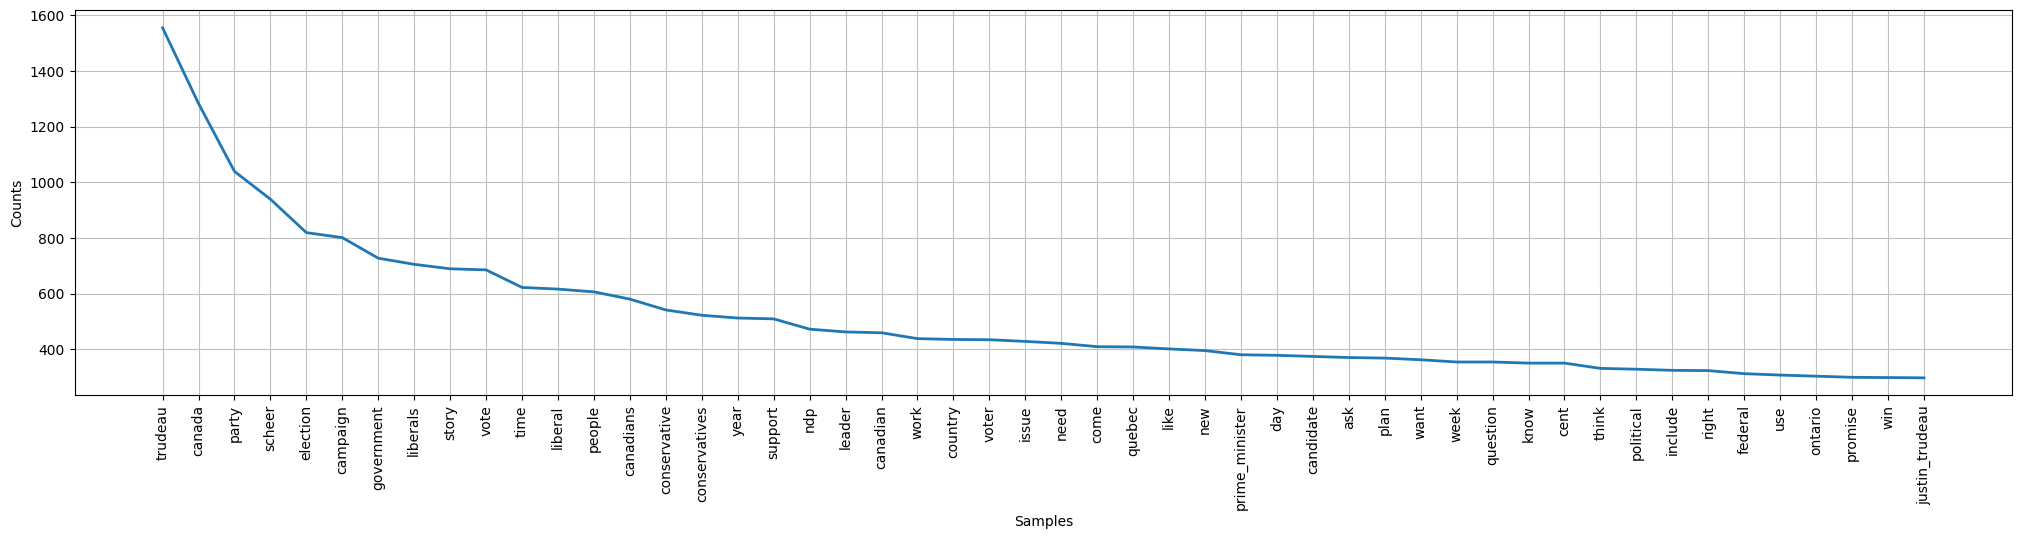

In [19]:
df_terms = term_frequency(df_news['text'])

#### Remoção de termos sem valor para o domínio

In [20]:
for term in df_terms['TERM'].to_list():
    if len(term) > 15:
        print("'" + term + "',")

'conservative_party',
'apologize_fail_tap_team',
'federal_election',
'conservative_leader_andrew_scheer',
'prime_minister_justin_trudeau',
'liberal_leader_justin_trudeau',
'election_campaign',
'federal_government',
'liberal_government',
'postmedia_network',
'minority_government',
'conservative_leader',
'ndp_leader_jagmeet_singh',
'british_columbia',
'conservative_government',
'network_latest_national_stories',
'soon_inbox_encounter_issue',
'click_unsubscribe_link_email',
'inc._365_bloor_street',
'ontario_m4w_3l4_416',
'thank_welcome_email_way',
'check_junk_folder_issue',
'story_midday_sun_newsroom',
'inbox_noon_late_headline',
'story_opinion_photo_toronto',
'sun_email_address_error',
'provide_valid_email_address',
'click_button_consent_receive',
'newsletter_postmedia_network_inc.',
'unsubscribe_time',
'liberals_conservatives',
'liberal_candidate',
'elections_canada',
'original_archive',
'conservative_candidate',
'federal_election_2019',
'cabinet_minister',
'jody_wilson_raybould',
'fren

#### A partir da lista acima, são selecionados manualmente quais termos devem ser removidos

In [21]:
unuseful_terms = [
    'apologize_fail_tap_team',
    'postmedia_network',
    'network_latest_national_stories',
    'soon_inbox_encounter_issue',
    'click_unsubscribe_link_email',
    'inc._365_bloor_street',
    'ontario_m4w_3l4_416',
    'thank_welcome_email_way',
    'check_junk_folder_issue',
    'story_midday_sun_newsroom',
    'inbox_noon_late_headline',
    'story_opinion_photo_toronto',
    'sun_email_address_error',
    'provide_valid_email_address',
    'click_button_consent_receive',
    'newsletter_postmedia_network_inc.',
    'unsubscribe_time',
    'original_archive'
]

def remove_unuseful_terms(text):
    return [token for token in text if token.lower() not in unuseful_terms]

df_news['text'] = df_news['text'].apply(remove_unuseful_terms)

## Identificação de tópicos com LDA

Referência: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

#### Criação do dicionário e corpus para o LDA usando o modelo BoW

In [22]:
from gensim.corpora.dictionary import Dictionary

# Cria o dicionário a partir do corpus
gs_dictionary = Dictionary(df_news['text'])

# Remove os tokens muito raros (menos frequentes que `no_below`) ou muito comuns (mais frequentes que `no_above`%)
gs_dictionary.filter_extremes(no_below=3, no_above=.20)

# Cria o corpus usando o modelo de Bag of Words
gs_corpus = [gs_dictionary.doc2bow(text) for text in df_news['text'].to_list()]

In [23]:
print('Dictionary size:', len(gs_dictionary), ', corpus size:', len(gs_corpus))

Dictionary size: 5429 , corpus size: 484


#### Treinamento de modelos LDA 

* Para treinar os modelos LDA usamos diferentes valores para $k$ 
* Nesse tutorial, escolhemos $k=10$ até $k=30$, uma vez que temos aprox. 500 documentos no corpus
* Para cada modelo geramos o score de coerência e perplexidade, que são analisados a seguir

In [24]:
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.ldamodel import LdaModel


def compute_lda_performance(dictionary, corpus, texts, start=1, limit=50, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    perplexity_values : Perplexity values corresponding to the LDA model with respective number of topics
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    num_topics_values = []
    perplexity_values = []
    coherence_values = []
    for num_topics in range(start, limit+step, step):
        num_topics_values.append(num_topics)

        model = LdaMulticore(corpus=corpus, num_topics=num_topics, iterations=1000, id2word=dictionary, passes=10, random_state=100) 

        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence = coherencemodel.get_coherence()
        coherence_values.append(coherence)

        perplexity = model.log_perplexity(corpus)
        perplexity_values.append(perplexity)

        print('Topics:', num_topics, '\tPerplexity:', round(perplexity, 5), '\tCoherence:', round(coherence, 5))

    df_results = pd.DataFrame({'topics': num_topics_values, 'perplexity': perplexity_values, 'coherence': coherence_values})
    return df_results

In [25]:
df_lda_models = compute_lda_performance(dictionary=gs_dictionary, corpus=gs_corpus, texts=df_news['text'], start=10, limit=30, step=2)

Topics: 10 	Perplexity: -8.10685 	Coherence: 0.33335
Topics: 12 	Perplexity: -8.13742 	Coherence: 0.33831
Topics: 14 	Perplexity: -8.16342 	Coherence: 0.35229
Topics: 16 	Perplexity: -8.18007 	Coherence: 0.35676
Topics: 18 	Perplexity: -8.203 	Coherence: 0.34176
Topics: 20 	Perplexity: -8.24075 	Coherence: 0.34105
Topics: 22 	Perplexity: -8.24503 	Coherence: 0.34483
Topics: 24 	Perplexity: -8.26594 	Coherence: 0.34496
Topics: 26 	Perplexity: -8.29038 	Coherence: 0.34632
Topics: 28 	Perplexity: -8.30374 	Coherence: 0.33877
Topics: 30 	Perplexity: -8.32211 	Coherence: 0.34508


#### Análise do score de coerência

* Indica o quão "interpretável" são os tópicos para humanos
* Indica o quanto as palavras mais representativas de cada tópico são similares entre si
* Diferentes medidas de similaridade podem ser usadas, a padrão é o score c_v, que usa similaridade do cosseno
* Heurística: quanto maior o score de coerência, melhor (mas nem sempre)
    * Usar método do "cotovelo"
    * Analisar o gráfico de tópicos (a seguir)
    * Usar bom senso

Text(0, 0.5, 'Coherence')

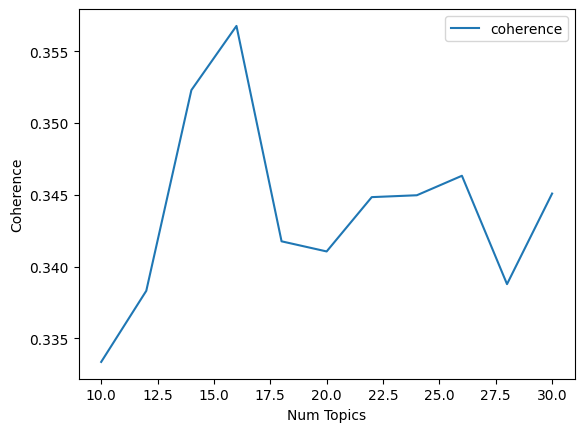

In [26]:
# Scores de coerência de acordo com o número de tópicos
ax = df_lda_models.plot.line(x='topics', y='coherence')
ax.set_xlabel("Num Topics")
ax.set_ylabel("Coherence")

In [27]:
# Top 5 modelos
df_lda_models.sort_values('coherence', ascending=False)[:5]

,topics,perplexity,coherence
3,16,-8.180068,0.356763
2,14,-8.163422,0.352289
8,26,-8.290379,0.346323
10,30,-8.322106,0.345083
7,24,-8.265940,0.344965


#### Identifica o melhor número de tópicos de acordo com o score de coerência

In [28]:
best_num_topics = df_lda_models.sort_values('coherence', ascending=False)['topics'].tolist()[0]

best_num_topics

16

#### Treinamento do modelo com o melhor número de tópicos 

Aqui repetimos o treinamento do modelo com o melhor número de tópicos usando uma quantidade maior de iterações e passes no dataset.

In [29]:
lda = LdaMulticore(corpus=gs_corpus, num_topics=best_num_topics, 
                   iterations=10000, id2word=gs_dictionary, passes=100, 
                   random_state=100)

#### Coerência e perplexidade do modelo final

In [30]:
# Compute Perplexity (lower is better)
print('\nPerplexity: ', lda.log_perplexity(gs_corpus)) 

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda, texts=df_news['text'], 
                                     dictionary=gs_dictionary, coherence='c_v')
print('\nCoherence Score: ', coherence_model_lda.get_coherence())


Perplexity:  -8.045706833339382

Coherence Score:  0.4392474752951263


#### Palavras mais representativas de cada tópico

Alguns exemplos de tópicos:

* **IMPOSTO DE CARBONO:** carbon_tax, emission, climate_change, tax, cbc, economy, cent, target, cost, program 
* **ABORTO:** abortion, debate, harper, comment, conservative_party, sex_marriage, law, view, conservative_leader, montreal 
* **PESQUISA ELEITORAL:** poll, mr._scheer, cent, mr._trudeau, survey, research, 30, age, positive, centre 
* **CORTE ORÇAMENTÁRIO:** billion, cut, platform, million, city, toronto, tax, bernier, budget, spending 
* **CASO DE RACISMO:** blackface, racist, apologize, black, apology, rcmp, woman, racism, global, makeup 
* **PETRÓLEO:** pipeline, oil, climate_change, climate, company, energy, encana, coal, spend, money 
* **IMIGRAÇÃO:** insurance, claim, refugee, comment, act, facebook, immigrant, immigration, insurance_broker, anti 

In [31]:
for i, topic in enumerate(lda.top_topics(topn=5, texts=df_news['text'])):
    terms = topic[0]
    print('Topic', i, ', '.join([term[1] for term in terms]))

Topic 0 indigenous, compensation, tribunal, child, decision
Topic 1 de, le, la, debate, que
Topic 2 alberta, western, albertans, project, provincial
Topic 3 blackface, racist, apologize, black, apology
Topic 4 pipeline, oil, climate_change, climate, company
Topic 5 journalist, racist, kinsella, man, write
Topic 6 seat, singh, poll, cent, bloc
Topic 7 abortion, debate, harper, comment, conservative_party
Topic 8 carbon_tax, emission, climate_change, tax, cbc
Topic 9 billion, cut, platform, million, city
Topic 10 poll, mr._scheer, cent, mr._trudeau, survey
Topic 11 mr., mp, foreign, mr._scheer, source
Topic 12 ford, u.s., education, deal, citizenship
Topic 13 insurance, claim, refugee, comment, act
Topic 14 bexte, event, member, volunteer, protest
Topic 15 china, woman, trump, library, 905


#### Visualização dos tópicos

* Cada bolha representa um tópico. Quanto maior a bolha, mais prevalente é esse tópico.
* Um bom modelo de tópico terá bolhas grandes e não sobrepostas espalhadas por todo o gráfico.
* Um modelo com muitos tópicos normalmente terá muitas sobreposições, bolhas de tamanho pequeno agrupadas em uma região do gráfico.

Fonte: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python

In [ ]:
import warnings
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

def show_lda_vis(lda, gs_corpus, gs_dictionary):
    # Workaround para evitar que o pyLDAvis esconda os botões do Jupyterlab
    from IPython.display import HTML
    css_str = '<style> \
    .jp-icon-warn0 path {fill: var(--jp-warn-color0);} \
    .bp3-button-text path { fill: var(--jp-inverse-layout-color3);} \
    .jp-icon-brand0 path { fill: var(--jp-brand-color0);} \
    text.terms { fill: #616161;} \
    </style>'
    display(HTML(css_str))

    # feed the LDA model into the pyLDAvis instance
    warnings.filterwarnings('ignore')
    return gensimvis.prepare(lda, gs_corpus, gs_dictionary)

In [ ]:
show_lda_vis(lda, gs_corpus, gs_dictionary)

#### Salva os 3 tópicos mais representativos de cada notícia no dataframe

In [34]:
topic_2_words = {}
for topic in lda.show_topics(num_topics=100, num_words=10, formatted=False):
    topic_id = topic[0]
    topic_tokens = ', '.join([token[0] for token in topic[1]])
    topic_2_words[topic_id] = topic_tokens

In [35]:
doc_topics_1 = []
doc_topics_1_words = []
doc_topics_1_percentages = []

doc_topics_2 = []
doc_topics_2_words = []
doc_topics_2_percentages = []

doc_topics_3 = []
doc_topics_3_words = []
doc_topics_3_percentages = []

for i, doc in enumerate(df_news['text'].to_list()):
    doc_bow = gs_dictionary.doc2bow(doc)
    
    # get document topics (each row contains a tuple with topic id and topic probability)
    doc_topics = lda.get_document_topics(doc_bow)
    
    # sort topics by probability
    doc_topics.sort(key=lambda x:x[1], reverse=True)
    
    # get them main topic and top 3 topics
    topics = doc_topics[:3]
    
    if len(topics) > 0:
        doc_topics_1_percentages.append(topics[0][1])
        topic_id = topics[0][0]
        doc_topics_1.append(topic_id)
        doc_topics_1_words.append(topic_2_words[topic_id])
    else:
        doc_topics_1.append(None)
        doc_topics_1_percentages.append(None)
        doc_topics_1_words.append(None)
        
        
    if len(topics) > 1:
        doc_topics_2_percentages.append(topics[1][1])
        topic_id = topics[1][0]
        doc_topics_2.append(topic_id)
        doc_topics_2_words.append(topic_2_words[topic_id])
    else:
        doc_topics_2.append(None)
        doc_topics_2_percentages.append(None)
        doc_topics_2_words.append(None)
        
        
    if len(topics) > 2:
        doc_topics_3_percentages.append(topics[2][1])
        topic_id = topics[2][0]
        doc_topics_3.append(topic_id)
        doc_topics_3_words.append(topic_2_words[topic_id])
    else:
        doc_topics_3.append(None)
        doc_topics_3_percentages.append(None)
        doc_topics_3_words.append(None)

In [36]:
df_news['topic'] = pd.Series(doc_topics_1)
df_news['topic_words'] = pd.Series(doc_topics_1_words)
df_news['topic_percentage'] = pd.Series(doc_topics_1_percentages)

df_news['topic_1'] = pd.Series(doc_topics_1)
df_news['topic_1_words'] = pd.Series(doc_topics_1_words)
df_news['topic_1_percentage'] = pd.Series(doc_topics_1_percentages)

df_news['topic_2'] = pd.Series(doc_topics_2)
df_news['topic_2_words'] = pd.Series(doc_topics_2_words)
df_news['topic_2_percentage'] = pd.Series(doc_topics_2_percentages)

df_news['topic_3'] = pd.Series(doc_topics_3)
df_news['topic_3_words'] = pd.Series(doc_topics_3_words)
df_news['topic_3_percentage'] = pd.Series(doc_topics_3_percentages)

#### Distribuição dos tópicos mais representativos em cada notícia

* O tópico mais representativo (em azul) tem alta dominância para a maioria das notícias
* O segundo e terceiro tópicos mais representativos, em laranja e verde, tem uma representatividade baixa na maioria das notícias em comparação com o azul. 

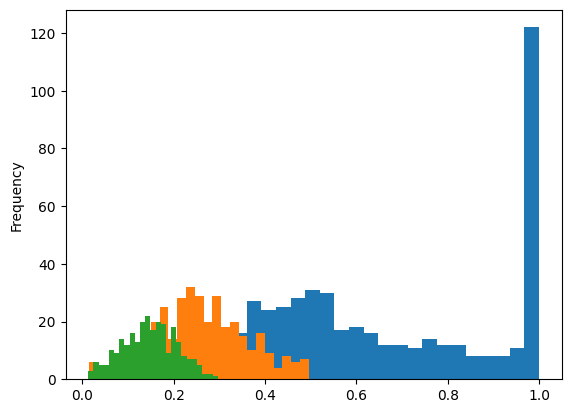

In [37]:
ax1 = pd.Series(doc_topics_1_percentages).plot.hist(bins=25)
ax2 = pd.Series(doc_topics_2_percentages).plot.hist(bins=25)
ax3 = pd.Series(doc_topics_3_percentages).plot.hist(bins=25)

#### Distribuição dos tópicos mais dominantes entre as notícias

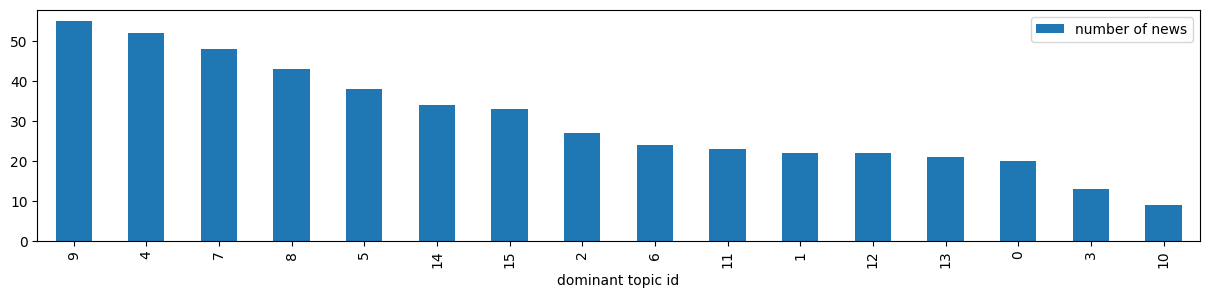

In [38]:
df = df_news.groupby('topic_1').agg({
    'article': 'count'
}).reset_index().rename(columns={
    'topic_1': 'dominant topic id',
    'article': 'number of news',
}).sort_values('number of news', ascending=False)

df['dominant topic id'] = df['dominant topic id'].astype('int')

ax = df.plot.bar(x='dominant topic id', y='number of news', figsize=(15,3))

In [39]:
df['number of news'].describe()

count    16.000000
mean     30.250000
std      13.718601
min       9.000000
25%      21.750000
50%      25.500000
75%      39.250000
max      55.000000
Name: number of news, dtype: float64

#### Exemplos de manchetes em 5 tópicos

In [40]:
for i in range(0, 5):
    print('\nTopic', i)
    print(df_news[df_news['topic'] == i]['title'][:5])


Topic 0
65                                                                    Federal election 2019 live results
161    NDP: Voters shouldn’t strategically vote unless they’re strategically voting NDP instead of Green
197                                   Tories hold 2.5-point lead over Liberals in latest Mainstreet poll
221                                                    Elizabeth May Said “Find Me Those Words.” We did.
233                                       Candidates Apologize for Advertising in Antisemitic Newspapers
Name: title, dtype: object

Topic 1
25                Liberal MP seen with radical activist once again despite past apology
56             'Seek and destroy' contract against PPC came with strings, Kinsella says
76                     Iqra Khalid Reappears with Radical Activist Despite Past Apology
85                               Scheer keeping platform and costs secret, Trudeau says
134    Opposition urges Ford government to release contract with Kinsella’s Da

In [41]:
def get_topic_1(url):
    df = df_news[df_news['url'] == url]
    return df.iloc[0]['topic'] if df.shape[0] == 1 else None

def get_topic_1_words(url):
    df = df_news[df_news['url'] == url]
    return df.iloc[0]['topic_words'] if df.shape[0] == 1 else None

df_retweeted_urls['topic'] = df_retweeted_urls['retweeted_url'].apply(get_topic_1)
df_retweeted_urls['topic_words'] = df_retweeted_urls['retweeted_url'].apply(get_topic_1_words)

### Resultados

Heatmap de tópicos vs retweets de usuários por faixa de polaridade

In [42]:
%matplotlib inline

def relative_polarity_heatmap(df, column, oversample=True, title=None, x_label=None, y_label_left=None, y_label_right=None, 
                              cbar_label=None, top_n=20, vmax=1, numeric_index=False, only_dataframe=False):
    
    env_polarities = [value/10 for value in range(-10,11,1)]
    
    df_copy = df.copy()    
    
    """
    -------------------
    RP(H) calculation
    -------------------
    """

    # generate a matrix with rows being 'column' parameter values and columns being polarities from -1 to +1
    df = pd.crosstab(index=df[column], columns=df['user_P(H)_bin'], values=df[column], aggfunc='count')
    df = df.fillna(0.0)
    
    # add faulting columns (for faulting polarities)
    for polarity in env_polarities:
        if not polarity in df.columns:
            num_rows = df.shape[0]
            df[polarity] = pd.Series([0.0] * num_rows)
            
    # reorder columns from -1.0 to +1.0
    df = df[env_polarities]
    
    # scale by dividing the retweets count of each polarity for each domain by the max retweets count of each polarity from all domains
    if oversample:
        df_polarity_max_retweets = df.max(axis=0) # get polarity column max value
        for polarity in env_polarities:
            df[polarity] = df[polarity] / df_polarity_max_retweets[polarity]    
    
    # normalize values to 0-1 interval with min-max (by domain min-max from all polarities)
    max_df = df.max(axis=1)
    min_df = df.min(axis=1)
    for polarity in env_polarities:
        df[polarity] = (df[polarity] - min_df) / (max_df - min_df) 
       
    # calculate polarity average without zeros and neutral users count
    relative_polarities = []
    for i, row in df.iterrows():
        row_sum = 0
        count = 0
        for polarity in env_polarities:
            if polarity != 0.0 and row[polarity] > 0.0: # only count cells with non zero value and remove the neutral polarity
                row_sum += row[polarity] * polarity
                count += row[polarity]
        if count > 0:
            relative_polarities.append(row_sum / count)
        else:
            relative_polarities.append(None)
        
    df['relative_polarity'] = relative_polarities
    
    
    """
    -------------------
    Data preparation
    -------------------
    """
    
    # count occurrences of 'column' values
    df_rphs = df_copy.groupby(column).agg(
        retweets_count=pd.NamedAgg(column=column, aggfunc='count')
    ).sort_values(by=column, ascending=False)
    df_rphs[column] = df.sort_index(ascending=False).index
    df_rphs['RP(H)'] = df.sort_index(ascending=False)['relative_polarity']
    
    """
    -------------------
    Data visualization
    -------------------
    """
    
    if not only_dataframe:
    
        # get only top N most retweeted 'column' values to include in the heatmap
        if top_n:        
            top_column_values = df_rphs.sort_values(by='retweets_count', ascending=False)[:top_n][column].unique()
            df = df[df.index.isin(top_column_values)]

        # sort heatmap rows by relative_polarity values
        df = df.sort_values('relative_polarity')
        relative_polarities = df['relative_polarity'].map('{:,.2f}'.format).astype('str').to_list()
        
        # drop relative_polarity to not include in the heatmap
        df = df.drop(columns=['relative_polarity'])
        df = df.fillna(0.0)        
            
        # get a print friendly datatable
        row_indexes = list(range(1,len(df.index)+1))
        row_values = df.index        
        df_heatmap_table = pd.DataFrame({'ID': row_indexes, y_label_left: row_values, 'RP(H)': relative_polarities})
        
        # create a sequential numeric 'id' for heatmap rows
        if numeric_index:            
            df['id'] = row_indexes
            df = df.set_index('id')

        plt.subplots(figsize=(2,round(top_n/3.5)))
        ax = sns.heatmap(df, annot=False, linewidths=.1, robust=True, cmap='YlOrBr', vmin=0, vmax=vmax, cbar=False, square=True)
        ax.set_title(title or '')
        ax.set_xlabel(x_label or 'User P(H)')
        ax.set_ylabel(y_label_left or '')
        #ax.collections[0].colorbar.set_label(cbar_label or 'Retweet density')
        ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
        ax.set_yticklabels(ax.get_yticklabels(), rotation = 0)

        # maintain only 5 tick labels to simplify
        for n, label in enumerate(ax.xaxis.get_ticklabels()):
            if n not in [0, 5, 10, 15, 20]:
                label.set_visible(False)

        # add right y axis
        ax2 = ax.twinx() # share x-axis
        ax2.set_ylabel(y_label_right or '')
        ax2.tick_params(right=True, pad=6)
        ax2.set_aspect('auto', share=True, )
        ax2.set_ylim((top_n, 0))
        ax2.set_yticks(ax.get_yticks())
        ax2.set_yticklabels(relative_polarities)
        ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        ax2.spines['bottom'].set_visible(False)
        ax2.spines['left'].set_visible(False)

        fig = ax.get_figure()
        fig.set_size_inches(2, round(top_n/3.5))

    return df_rphs, df_heatmap_table, fig

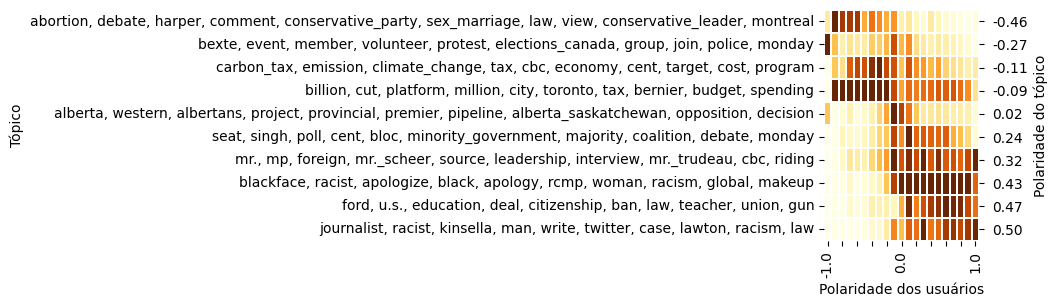

In [45]:
warnings.filterwarnings('ignore')
df, df_heatmap, fig = relative_polarity_heatmap(
    df=df_retweeted_urls, column='topic_words', y_label_left='Tópico', 
    y_label_right='Polaridade do tópico', x_label='Polaridade dos usuários',
    top_n=10
)